In [153]:
import numpy as np
import pandas as pd
import os
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy

sns.set_theme()

In [154]:
path = "FinalProjectData"

data = pd.concat(
    [pd.read_csv(os.path.join(path, f)) for f in os.listdir(path) if f.endswith(".csv")]
)
data["PSUM"] = np.sum([data["P" + str(n)] for n in range(1,8)], axis=0)
data["NSUM"] = np.sum([data["N" + str(n)] for n in range(1,8)], axis=0)
data["GSUM"] = np.sum([data["G" + str(n)] for n in range(1,17)], axis=0)
data["Treatment"] = data["TxGroup"] == "Treatment"
passed_data = data[data["LeadStatus"] == "Passed"]
first_day_passed_data = passed_data[passed_data["VisitDay"] == 0]
data

,Study,Country,PatientID,SiteID,RaterID,AssessmentID,TxGroup,VisitDay,P1,P2,...,G13,G14,G15,G16,PANSS_Total,LeadStatus,PSUM,NSUM,GSUM,Treatment
0,A,USA,10001,20035,30076,100679,Control,0,5,5,...,3,3,3,5,107,Assign to CS,30,24,53,False
1,A,USA,10001,20035,30076,101017,Control,11,5,5,...,3,3,3,5,109,Assign to CS,30,25,54,False
2,A,USA,10001,20035,30076,102177,Control,18,4,4,...,3,2,3,4,91,Passed,23,24,44,False
3,A,USA,10001,20035,30076,101533,Control,25,3,3,...,3,2,3,4,80,Flagged,19,22,39,False
4,A,USA,10001,20035,30076,100930,Control,39,3,3,...,3,2,3,4,77,Flagged,19,21,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,D,China,40223,80001,120013,400496,Treatment,17,4,3,...,2,2,4,4,79,Flagged,18,21,40,True
2944,D,China,40223,80001,120013,402261,Treatment,21,4,3,...,2,2,3,3,71,Flagged,18,18,35,True
2945,D,China,40223,80001,120013,400605,Treatment,28,4,3,...,2,2,3,3,74,Flagged,19,19,36,True
2946,D,China,40223,80001,120013,402460,Treatment,42,4,3,...,2,2,4,3,77,Flagged,19,20,38,True


# 1 Treatment effect

We will clearly define our tests before observing or analyzing the data to simulate the regulations that prevent data snooping in regulated industries. The goal is to determine if the treatment ( $\text{TxGroup} == \text{Treatment}$, which will be our preprocessing step ) has an effect on schizophrenia over time, as measured by the PANSS score ( $\text{PANSS\_Total}$ ). So, we want to see if there is a change in $\text{PANSS\_Total}$ over time, which can be determined by looking for a correlation between $\text{VisitDay}$ and $\text{PANSS\_Total}$ using a linear regression model:

$$\text{PANSS\_Total}=\hat{\beta_0}+\hat{\beta_1}\text{VisitDay}$$

Our null hypothesis is that the treatment has no effect, and we can reject the null hypothesis if and only if we find that $\hat{\beta_1}\neq 0$ with a $p<0.05$.

In [155]:
smf.ols(
    "PANSS_Total ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Treatment"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     5037.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:04   Log-Likelihood:                -30955.
No. Observations:                7626   AIC:                         6.191e+04
Df Residuals:                    7624   BIC:                         6.193e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.9045      0.228    358.868      0.000      81.457      82.352
VisitDay      -0.1125      0.002    -70.970      0.000      -0.116      -0.109
==============================================================================
Omnibus:                      190.937   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.247
Skew:                           0.352   Prob(JB):                     4.06e-48
Kurtosis:                       3.438   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
smf.ols(
    "PSUM ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Treatment"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PSUM   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     3911.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:04   Log-Likelihood:                -23007.
No. Observations:                7626   AIC:                         4.602e+04
Df Residuals:                    7624   BIC:                         4.603e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.6723      0.080    244.404      0.000      19.514      19.830
VisitDay      -0.0350      0.001    -62.537      0.000      -0.036      -0.034
==============================================================================
Omnibus:                      332.316   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              375.993
Skew:                           0.536   Prob(JB):                     2.26e-82
Kurtosis:                       3.189   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
smf.ols(
    "NSUM ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Treatment"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NSUM   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     1930.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:04   Log-Likelihood:                -22671.
No. Observations:                7626   AIC:                         4.535e+04
Df Residuals:                    7624   BIC:                         4.536e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.0666      0.077    286.486      0.000      21.916      22.218
VisitDay      -0.0235      0.001    -43.931      0.000      -0.025      -0.022
==============================================================================
Omnibus:                       42.064   Durbin-Watson:                   0.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.992
Skew:                           0.172   Prob(JB):                     4.62e-10
Kurtosis:                       3.133   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
smf.ols(
    "GSUM ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Treatment"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GSUM   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     4273.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:04   Log-Likelihood:                -25990.
No. Observations:                7626   AIC:                         5.198e+04
Df Residuals:                    7624   BIC:                         5.200e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.1657      0.119    337.477      0.000      39.932      40.399
VisitDay      -0.0540      0.001    -65.368      0.000      -0.056      -0.052
==============================================================================
Omnibus:                      229.079   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.955
Skew:                           0.393   Prob(JB):                     4.82e-58
Kurtosis:                       3.462   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

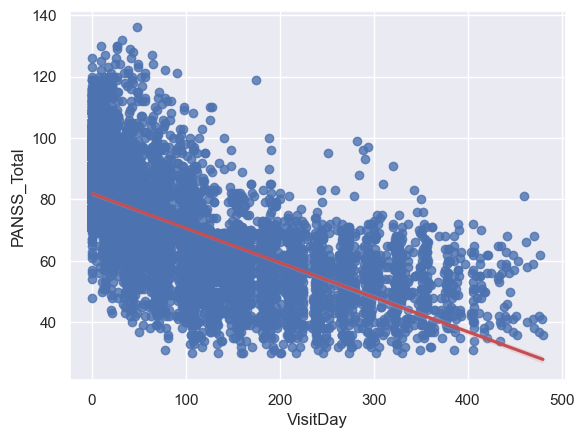

In [159]:
sns.regplot(
    x="VisitDay",
    y="PANSS_Total",
    data=passed_data[passed_data["TxGroup"] == "Treatment"],
    line_kws={"color": "C3"},
)
plt.show()

This shows a p-value well below $0.05$ for a nonzero $\hat{\beta}_0$, so we reject the null hypothesis and can say that the treatment plan does improve the PANSS score over time. Additionally, the coefficient $\hat{\beta}_1\approx 0.1134$ indicates that the treatment will decrease the PANSS score by approximately $0.1134$ every day.

In [160]:
smf.ols(
    "PANSS_Total ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Control"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     5348.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -33510.
No. Observations:                8215   AIC:                         6.702e+04
Df Residuals:                    8213   BIC:                         6.704e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.9635      0.224    370.665      0.000      82.525      83.402
VisitDay      -0.1177      0.002    -73.133      0.000      -0.121      -0.115
==============================================================================
Omnibus:                      228.182   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.525
Skew:                           0.349   Prob(JB):                     2.00e-61
Kurtosis:                       3.573   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
smf.ols(
    "PSUM ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Control"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PSUM   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     3969.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -25145.
No. Observations:                8215   AIC:                         5.029e+04
Df Residuals:                    8213   BIC:                         5.031e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.9753      0.081    247.057      0.000      19.817      20.134
VisitDay      -0.0366      0.001    -63.000      0.000      -0.038      -0.035
==============================================================================
Omnibus:                      449.170   Durbin-Watson:                   0.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              525.612
Skew:                           0.598   Prob(JB):                    7.32e-115
Kurtosis:                       3.321   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
smf.ols(
    "NSUM ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Control"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NSUM   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     1935.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -24544.
No. Observations:                8215   AIC:                         4.909e+04
Df Residuals:                    8213   BIC:                         4.911e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2323      0.075    295.840      0.000      22.085      22.380
VisitDay      -0.0238      0.001    -43.986      0.000      -0.025      -0.023
==============================================================================
Omnibus:                      133.402   Durbin-Watson:                   0.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.377
Skew:                           0.262   Prob(JB):                     3.00e-34
Kurtosis:                       3.421   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
smf.ols(
    "GSUM ~ VisitDay", data=passed_data[passed_data["TxGroup"] == "Control"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GSUM   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     4648.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -28174.
No. Observations:                8215   AIC:                         5.635e+04
Df Residuals:                    8213   BIC:                         5.637e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.7559      0.117    348.632      0.000      40.527      40.985
VisitDay      -0.0573      0.001    -68.173      0.000      -0.059      -0.056
==============================================================================
Omnibus:                      271.787   Durbin-Watson:                   0.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.699
Skew:                           0.417   Prob(JB):                     4.61e-69
Kurtosis:                       3.473   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

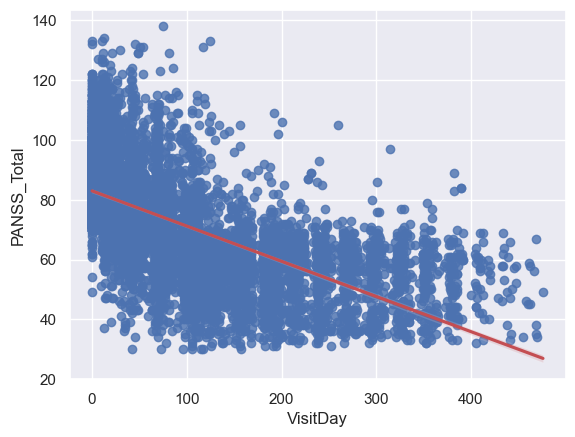

In [164]:
sns.regplot(
    x="VisitDay",
    y="PANSS_Total",
    data=passed_data[passed_data["TxGroup"] == "Control"],
    line_kws={"color": "C3"},
)
plt.show()

In [165]:
smf.ols(
    "PANSS_Total ~ VisitDay*Treatment", data=passed_data
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     3467.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -64467.
No. Observations:               15841   AIC:                         1.289e+05
Df Residuals:                   15837   BIC:                         1.290e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     82.9635      0.222    374.211      0.000      82.529      83.398
Treatment[T.True]             -1.0590      0.320     -3.310      0.001      -1.686      -0.432
VisitDay                      -0.1177      0.002    -73.833      0.000      -0.121      -0.115
VisitDay:Treatment[T.True]     0.0053      0.002      2.330      0.020       0.001       0.010
==============================================================================
Omnibus:                      418.754   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.541
Skew:                           0.351   Prob(JB):                    9.13e-109
Kurtosis:                       3.512   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
smf.ols(
    "PSUM ~ VisitDay*Treatment", data=passed_data
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PSUM   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     2627.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -48160.
No. Observations:               15841   AIC:                         9.633e+04
Df Residuals:                   15837   BIC:                         9.636e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     19.9753      0.079    252.221      0.000      19.820      20.131
Treatment[T.True]             -0.3030      0.114     -2.652      0.008      -0.527      -0.079
VisitDay                      -0.0366      0.001    -64.317      0.000      -0.038      -0.036
VisitDay:Treatment[T.True]     0.0017      0.001      2.087      0.037       0.000       0.003
==============================================================================
Omnibus:                      786.417   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              907.748
Skew:                           0.571   Prob(JB):                    7.67e-198
Kurtosis:                       3.269   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
smf.ols(
    "NSUM ~ VisitDay*Treatment", data=passed_data
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NSUM   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1291.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -47217.
No. Observations:               15841   AIC:                         9.444e+04
Df Residuals:                   15837   BIC:                         9.447e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     22.2323      0.075    297.944      0.000      22.086      22.379
Treatment[T.True]             -0.1657      0.108     -1.539      0.124      -0.377       0.045
VisitDay                      -0.0238      0.001    -44.299      0.000      -0.025      -0.023
VisitDay:Treatment[T.True]     0.0003      0.001      0.367      0.713      -0.001       0.002
==============================================================================
Omnibus:                      166.462   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.395
Skew:                           0.219   Prob(JB):                     4.08e-40
Kurtosis:                       3.287   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
smf.ols(
    "GSUM ~ VisitDay*Treatment", data=passed_data
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GSUM   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     2979.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:26:05   Log-Likelihood:                -54166.
No. Observations:               15841   AIC:                         1.083e+05
Df Residuals:                   15837   BIC:                         1.084e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     40.7559      0.116    352.228      0.000      40.529      40.983
Treatment[T.True]             -0.5903      0.167     -3.535      0.000      -0.918      -0.263
VisitDay                      -0.0573      0.001    -68.877      0.000      -0.059      -0.056
VisitDay:Treatment[T.True]     0.0033      0.001      2.799      0.005       0.001       0.006
==============================================================================
Omnibus:                      500.923   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.379
Skew:                           0.406   Prob(JB):                    9.38e-127
Kurtosis:                       3.470   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can say with statistical significance that the control treatment is more effective than the new treatment, with a $\hat{\beta'}_1\approx -0.1208$ versus $\hat{\beta}_1\approx -0.1134$, however, that does not mean that the new treatment is ineffective. For example, if it has other advantages like few side effects or lower cost, preventing the control treatment from being an option, this study showing the efficacy of the new treatment could be critical information. Overall, it is not more effective / an improvement over the control, but based on existing research it is significantly better than untreated Schizophrenia, which often gets worse over time. However, **it is effective**.

**ADD MORE ANALISYS HERE** talk about how the inital treatment group tends to be less schizophrenic than the control group. Solving this could be the object of a future study that is randmly assigns control and treatment such that the intial values are identical, becuase trying to artifically normilize them in this study, given that the initial groups are statistically significantly different, will result in other ( possibly unseen ) artifacts.

# 2 Patient segmentation

First, we need to preprocess the data. We want to filter the data only to consider initial measurements of patients, and we want to scale each of the variables used in the evaluation to zero means and unit variance for equal emphasis on more and less sensitive measurements.

In [169]:
numerical_first_day_passed_data = first_day_passed_data.drop(
    [
        "Study",
        "Country",
        "PatientID",
        "SiteID",
        "RaterID",
        "AssessmentID",
        "TxGroup",
        "VisitDay",
        "PANSS_Total",
        "LeadStatus",
    ],
    axis=1,
)
scaled_numerical_first_day_passed_data = StandardScaler().fit_transform(numerical_first_day_data)

Also, let's check if there are many double first day measurments to see if that could skew the data

In [170]:
len(first_day_passed_data["PatientID"])

1747

In [171]:
len(np.unique(first_day_passed_data["PatientID"]))

1745

Nope, that is not a problem so we can ignore that as a possible skew of the data.

Now we can run a highirichical clustering to create a dendrogram since our dataset is relatively small

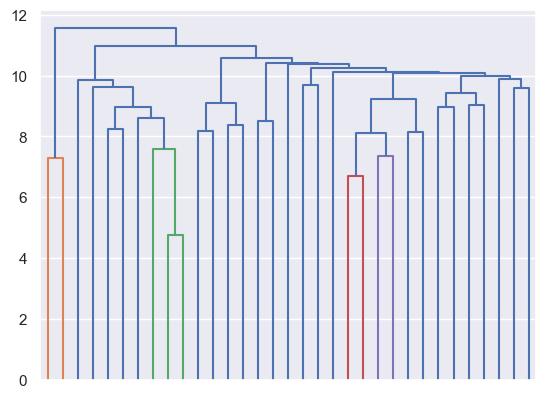

In [172]:
dendrogram(linkage(scaled_numerical_first_day_passed_data, method="average"), truncate_mode="level", p=10, no_labels=True)
plt.show()

$3$ seems like the most sensible value. To confirm these values, let's run a KMeans $n$ vs. $\text{error}$ to confirm this cluster size.

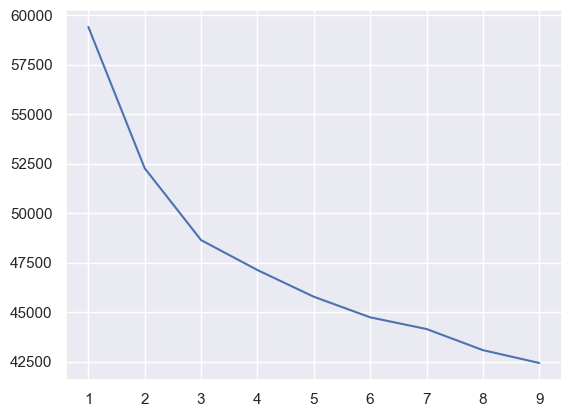

In [173]:
sns.lineplot(
    x=range(1, 10),
    y=[
        KMeans(n_clusters=n, random_state=42, n_init="auto").fit(scaled_numerical_first_day_passed_data).inertia_
        for n in range(1, 10)
    ],
)
plt.show()

The new graph confirms that $3$ is a valid choice because it is not in a flattening zone but does not provide enough information to support $5$ or any other large value. So, let's go with $k=5$.

In [174]:
cluster_labels = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(scaled_numerical_first_day_passed_data).labels_
clusters = [first_day_data[cluster_labels == n] for n in range(5)]

In [175]:
[np.average(clusters[i]["PANSS_Total"]) for i in range(3)]

[80.6501547987616, 102.29593810444874, 83.15068493150685]

In [177]:
[np.average(clusters[i]["NSUM"]) for i in range(3)]

[23.823529411764707, 26.833655705996133, 18.977739726027398]

In [178]:
[np.average(clusters[i]["PSUM"]) for i in range(3)]

[17.224458204334365, 25.427466150870405, 23.10958904109589]

In [179]:
[np.average(clusters[i]["GSUM"]) for i in range(3)]

[39.60216718266254, 50.03481624758221, 41.06335616438356]

In [176]:
# pd.DataFrame(
#     {
#         "P1-P7": np.average(
#             clusters_table[["P" + str(n) for n in range(1, 8)]], axis=1
#         ),
#         "N1-N7": np.average(
#             clusters_table[["N" + str(n) for n in range(1, 8)]], axis=1
#         ),
#         "G1-G16": np.average(
#             clusters_table[["G" + str(n) for n in range(1, 17)]], axis=1
#         ),
#     },
# )

The clusters that form are
- **Cluster 1:** Exhibit slightly more positive and significantly more negative and general schizophrenic metrics than average
- **Cluster 2:** Exhibit significantly less positive, negative, and general schizophrenic metrics than average
- **Cluster 3:** Exhibit significantly more positive, and slightly more negative and general schizophrenic metrics than average
- **Cluster 4:** Exhibit less positive, a tiny bit less general, and more negative schizophrenic metrics than average
- **Cluster 5:** Exhibit slightly more positive, less negative, and the tiniest bit less general metrics than average.
In these groups, groups $1$ and $3$ would be the most important to look into because they will be the most likely to have schizophrenia-related problems, and this shows approximately what type of problems may arise in those groups ( the generally more negative problem groups with still a significant amount of positive and general, and more positive groups with a significant amount of general and less negative ). This also provides the basis for further investigation into the specifics of each metric. However, as a simple clustering algorithm, these results should be taken lightly not to mean that groups $2$ and $4$ are the only important ones.

# 3 Forecasting

